In [1]:
import pandas as pd
import matplotlib.pyplot as plt  # Import the plotting library
import seaborn as sns

import numpy as np


from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string


import re

import json
# download nltk corpus (first time only)
import nltk

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')




def missing_values_table(df, table=True):
    mis_val = df.isnull().sum()
    
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    
    types = df.dtypes
    types.replace({'object': 'str'}, inplace=True)
    
    mis_val_table = pd.concat([mis_val, mis_val_percent, types], axis=1)
    
    mis_val_table_ren_columns = mis_val_table.rename(
        columns={0: 'Missing Values', 1: '% of Total Values', 2: 'Type'})
    
    mis_val_table_ren_columns = mis_val_table_ren_columns.sort_values('% of Total Values', ascending=False).round(1)
    
    print("Your selected dataframe has " + str(df.shape[1]) + " columns.\n")
    
    # Add plot
    plt.figure(figsize=(13, 6))
    sns.set(style="whitegrid", color_codes=True)
    sns.barplot(x=mis_val_table_ren_columns.index, y=mis_val_table_ren_columns["% of Total Values"], data=mis_val_table_ren_columns)
    plt.xticks(rotation=90)
    plt.title("Missing values count")
    plt.show()
    
    if table:
        return mis_val_table_ren_columns


def drop_func(df, prc, lst_col_keep):
    columns_to_drop = []  
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    for col in df.columns:
        if mis_val_percent[col] >= prc and col not in lst_col_keep:
            columns_to_drop.append(col)
    return columns_to_drop


def check_sentence_for_word(sentence, lst):
    result_list = []  
    float_values = []  

    words = sentence.split()  

    for i, word in enumerate(words):
        if word in lst:
            if i > 0:  
                before = words[i - 1]
                if is_float(before):
                    float_values.append(float(before))
            if i < len(words) - 1:  
                after = words[i + 1]
                if is_float(after):
                    float_values.append(float(after))

    if float_values:
        max_float = max(float_values)
        result_list.append(max_float)

    return first_element_or_nan(result_list)

def is_float(word):
    try:
        float(word)
        return True
    except ValueError:
        return False
    
    


def first_element_or_nan(lst):
    if lst:
        return lst[0]
    else:
        return np.nan 


def split_measurement_strings(text):
    
    pattern = r'(\d+)\s*([m²])'

    result = re.sub(pattern, r'\1 \2', text)

    return result



def preprocess_text_nltk(text):

    # Tokenize the text
    tokens = word_tokenize(text.lower())
    # Remove stop words
    filtered_tokens = [token for token in tokens if token not in stopwords.words('french')]
    # Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    # Join the tokens back into a string
    processed_text = ' '.join(lemmatized_tokens)
    
    processed_text = split_measurement_strings(processed_text)
    # remove ponct
    exclude = set(string.punctuation)
    processed_text = ''.join(ch for ch in processed_text if ch not in exclude)
    return processed_text




[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Amine\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Amine\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Amine\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Objectf:

#### Le but de cette partie est d'analyser les données, d'observer comment elles sont liées les unes aux autres, de traiter les valeurs manquantes et de créer d'autres variables qui peuvent nous aider à résoudre notre problème.

In [2]:
# load & general data cleaning
DATA_PATH = "../data/raw_data_.csv"

data = pd.read_csv(DATA_PATH)

# drop completely NA columns
data.dropna(
    how="all",
    axis=1,
    inplace=True
)

# drop constant columns
filter_const_cols = (data != data.iloc[0]).any(axis=0)
data = data.loc[:, filter_const_cols]

# drop ID
data.drop(
    labels=[
        "ID",
        "URL",  # we won't re scrap the website again
        "ZIP_CODE"
    ],
    axis=1,
    inplace=True
)

In [3]:
# columns to be leveraged later
USELESS_COL = [
    # "CRAWL_SOURCE", 
    "IMAGES", 
    # "DESCRIPTION",
    # "PUBLICATION_START_DATE", "LAST_CRAWL_DATE", 
    "LAST_PRICE_DECREASE_DATE", "HEATING_TYPES"
    # "PRICE_EVENTS",
]
data_useful = data.drop(labels=USELESS_COL, axis=1)

data_useful['PUBLICATION_START_DATE'] = pd.to_datetime(data['PUBLICATION_START_DATE'])
data_useful['LAST_CRAWL_DATE'] = pd.to_datetime(data['LAST_CRAWL_DATE'])

data_useful['pub_strt_date_ym'] = data_useful['PUBLICATION_START_DATE'].dt.strftime('%Y-%m')
data_useful['last_crawl_date_ym'] = data_useful['LAST_CRAWL_DATE'].dt.strftime('%Y-%m')

def calculate_days(row):
    date_difference = row['LAST_CRAWL_DATE'] - row['PUBLICATION_START_DATE']
    return date_difference.days

# Appliquer la fonction à chaque ligne pour calculer le nombre de jours
data_useful['Days_Between'] = data_useful.apply(calculate_days, axis=1)

In [4]:
lst_col_keep = []
prc = 70
columns_to_drop = drop_func(data_useful, prc, lst_col_keep)

In [5]:
columns_to_drop

['LAND_SURFACE',
 'TERRACE_SURFACE',
 'FURNISHED',
 'GARDEN',
 'SWIMMING_POOL',
 'TERRACE',
 'PARKING_COUNT',
 'FLOOR_COUNT',
 'CONSTRUCTION_YEAR',
 'ELEVATOR',
 'CARETAKER',
 'RENTAL_EXPENSES',
 'RENTAL_EXPENSES_INCLUDED',
 'DEPOSIT',
 'FEES',
 'FEES_INCLUDED',
 'AGENCIES_UNWANTED']

In [6]:
data_useful = data_useful.drop(columns=columns_to_drop)

Your selected dataframe has 23 columns.



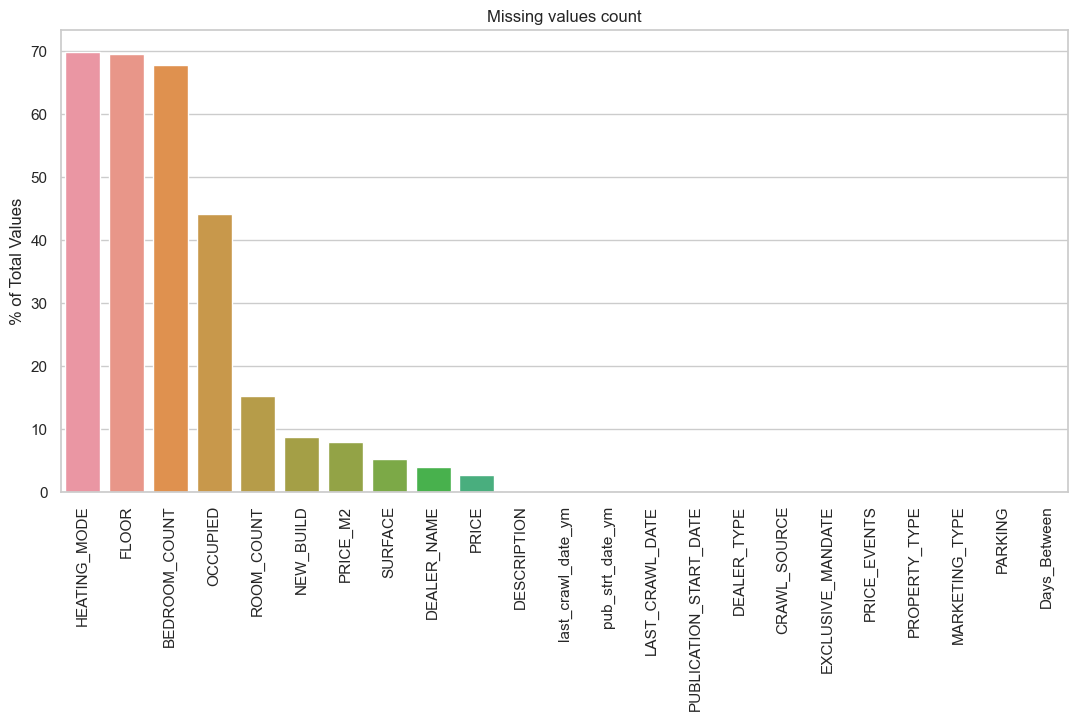

,Missing Values,% of Total Values,Type
HEATING_MODE,1511,69.8,str
FLOOR,1504,69.5,float64
BEDROOM_COUNT,1468,67.8,float64
OCCUPIED,955,44.1,str
ROOM_COUNT,329,15.2,float64
NEW_BUILD,191,8.8,str
PRICE_M2,173,8.0,float64
SURFACE,114,5.3,float64
DEALER_NAME,87,4.0,str
PRICE,60,2.8,float64


In [7]:
missing_values_table(data_useful)

In [8]:
# create preprocess_text function
def preprocess_text(text):
    # Tokenize the text
    tokens = word_tokenize(text.lower())
    # Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    # Join the tokens back into a string
    processed_text = ' '.join(lemmatized_tokens)
    
    processed_text = split_measurement_strings(processed_text)

    return processed_text

In [9]:
df = data_useful.query("(SURFACE.isna()) & (PROPERTY_TYPE != 'PARKING')")

In [10]:
df['PROPERTY_TYPE'].value_counts()

APARTMENT    20
PREMISES      9
HOUSE         5
BUILDING      2
Name: PROPERTY_TYPE, dtype: int64

In [11]:
df['DESCRIPTION'] = df['DESCRIPTION'].apply(preprocess_text)

lst = ['m²']

def fill_surface(row):
    surface = check_sentence_for_word(row['DESCRIPTION'], lst)
    return row['SURFACE'] if not pd.isna(row['SURFACE']) else surface

df['SURFACE'] = df.apply(fill_surface, axis=1)


C:\Users\Amine\AppData\Local\Temp\ipykernel_12020\3109761167.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DESCRIPTION'] = df['DESCRIPTION'].apply(preprocess_text)
C:\Users\Amine\AppData\Local\Temp\ipykernel_12020\3109761167.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SURFACE'] = df.apply(fill_surface, axis=1)


In [12]:
updated_data_useful = data_useful.copy()
updated_data_useful.loc[df.index] = df

Your selected dataframe has 23 columns.



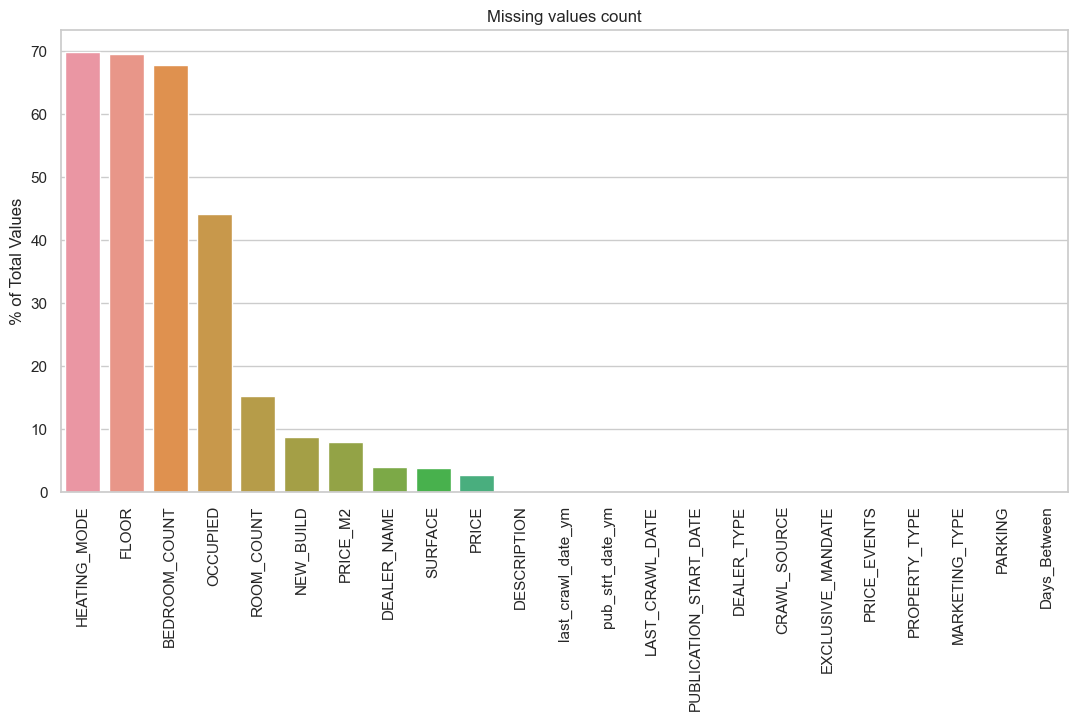

,Missing Values,% of Total Values,Type
HEATING_MODE,1511,69.8,str
FLOOR,1504,69.5,float64
BEDROOM_COUNT,1468,67.8,float64
OCCUPIED,955,44.1,str
ROOM_COUNT,329,15.2,float64
NEW_BUILD,191,8.8,str
PRICE_M2,173,8.0,float64
DEALER_NAME,87,4.0,str
SURFACE,85,3.9,float64
PRICE,60,2.8,float64


In [13]:
missing_values_table(updated_data_useful)

In [14]:
df_p = updated_data_useful.query("(SURFACE.isna()) & (PROPERTY_TYPE == 'PARKING')")

In [15]:
def fill_surface(row, df):
    mean_surface = round(df[df['PROPERTY_TYPE'] == 'PARKING']['SURFACE'].mean(), 2)
    return row['SURFACE'] if not pd.isna(row['SURFACE']) else mean_surface

df_p['SURFACE'] = df_p.apply(lambda row: fill_surface(row, updated_data_useful), axis=1)


C:\Users\Amine\AppData\Local\Temp\ipykernel_12020\2647681271.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_p['SURFACE'] = df_p.apply(lambda row: fill_surface(row, updated_data_useful), axis=1)


In [16]:
updated_data_useful_2 = updated_data_useful.copy()
updated_data_useful_2.loc[df_p.index] = df_p

Your selected dataframe has 23 columns.



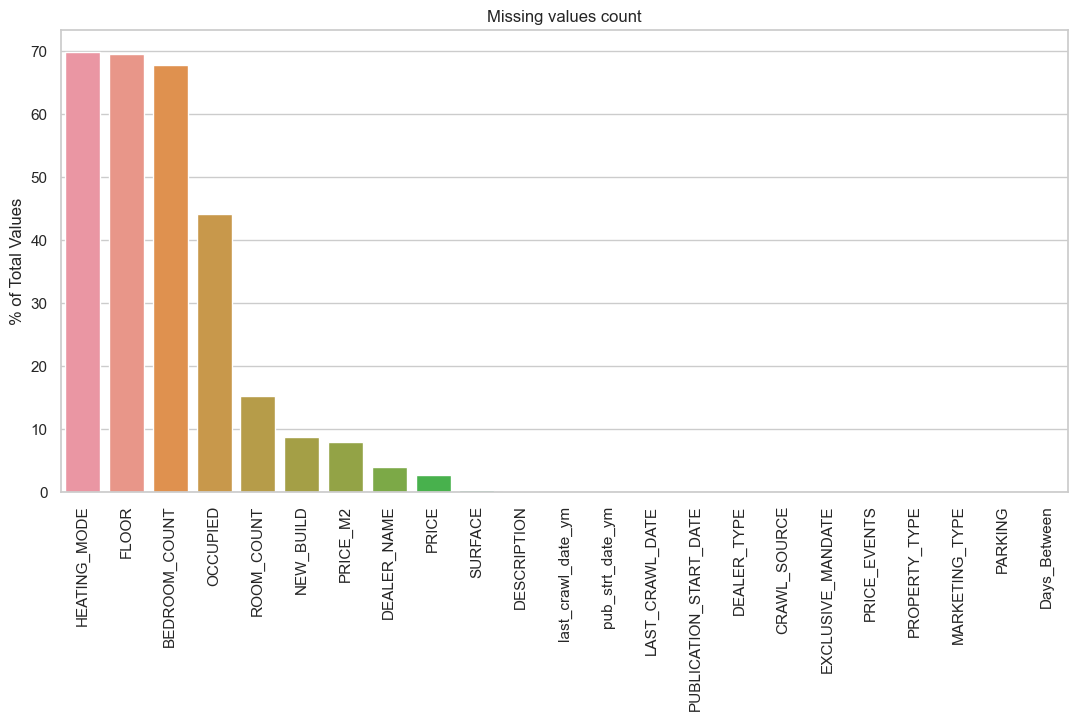

In [17]:
missing_values_table(updated_data_useful_2, False)

In [18]:
# filling price for missig values Apprt's price

df_missing_price = updated_data_useful_2.query("(MARKETING_TYPE == 'RENT') & (PROPERTY_TYPE.isin(['PREMISES', 'BUILDING'])) & (PRICE.isna())")

In [19]:
def calculate_mean_price(json_string):
    data_list = json.loads(json_string)
    prices = [entry['price'] for entry in data_list]
    return sum(prices) / len(prices)

df_missing_price['PRICE'] = df_missing_price['PRICE_EVENTS'].apply(calculate_mean_price)

C:\Users\Amine\AppData\Local\Temp\ipykernel_12020\1984082234.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_missing_price['PRICE'] = df_missing_price['PRICE_EVENTS'].apply(calculate_mean_price)


In [20]:
updated_data_useful_3 = updated_data_useful_2.copy()
updated_data_useful_3.loc[df_missing_price.index] = df_missing_price

Your selected dataframe has 23 columns.



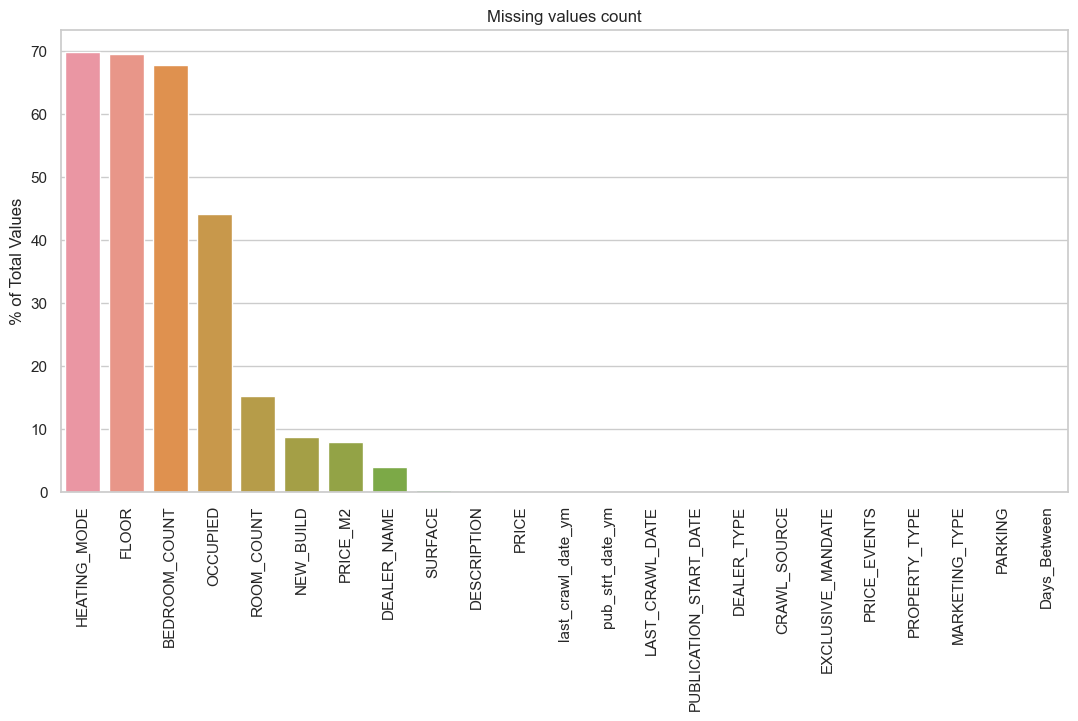

,Missing Values,% of Total Values,Type
HEATING_MODE,1511,69.8,str
FLOOR,1504,69.5,float64
BEDROOM_COUNT,1468,67.8,float64
OCCUPIED,955,44.1,str
ROOM_COUNT,329,15.2,float64
NEW_BUILD,191,8.8,str
PRICE_M2,173,8.0,float64
DEALER_NAME,87,4.0,str
SURFACE,7,0.3,float64
DESCRIPTION,4,0.2,str


In [21]:
missing_values_table(updated_data_useful_3)

### NEW_BUILD feature


#### On va essayer de voir les valeurs manquantes de la variable NEW_BUILD et sa relation avec PROPRITY_TYPE 

In [22]:
print(f'On a {round((updated_data_useful_3["NEW_BUILD"].isna().sum() / len(updated_data_useful_3)) * 100, 2)} % de valeurs manquantes, une {updated_data_useful_3["NEW_BUILD"].isna().sum()} de valeurs manquantes.')



On a 8.83 % de valeurs manquantes, une 191 de valeurs manquantes.


#### Nous allons essayer de comprendre pourquoi, et posser une hypothèse.

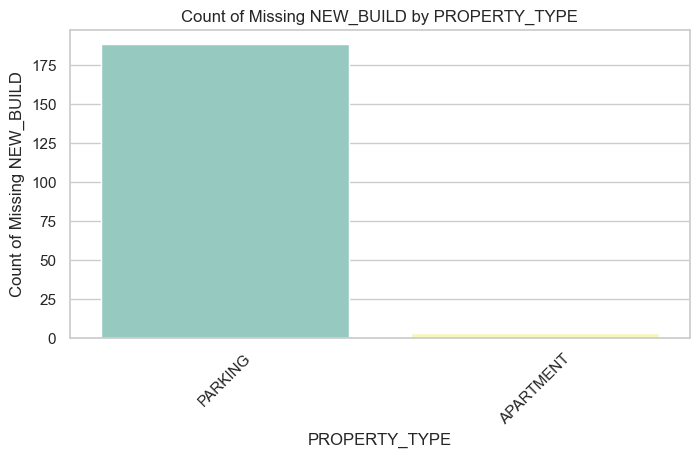

PARKING      188
APARTMENT      3
Name: PROPERTY_TYPE, dtype: int64

In [23]:
missing_build_counts = updated_data_useful_3.query("NEW_BUILD.isna()")['PROPERTY_TYPE'].value_counts()

plt.figure(figsize=(8, 4))
sns.barplot(x=missing_build_counts.index, y=missing_build_counts.values, palette="Set3")
plt.xlabel("PROPERTY_TYPE")
plt.ylabel("Count of Missing NEW_BUILD")
plt.title("Count of Missing NEW_BUILD by PROPERTY_TYPE")
plt.xticks(rotation=45)  
plt.show()

missing_build_counts

#### Nous remarquons que la plupart des valeurs manquantes sont des parkings, ce qui signifie que l'information dans NEW_BUILD n'est pas intéressante pour le type de propriété tel qu'un parking, ce qui explique pourquoi la personne rédigeant l'annonce n'est pas intéressée à le mentionner.

#### Pour ce faire, nous allons remplir cette valeur avec "-1" et supprimer les lignes d'appartement. Certes, ce n'est pas la meilleure solution, mais en supposant que dans la majorité des cas, si ce n'est tous, nous n'avons que les parkings sans cette valeur.

In [24]:
df_new_build = updated_data_useful_3.query("NEW_BUILD.isna() & PROPERTY_TYPE == 'PARKING'")

In [25]:
df_new_build["NEW_BUILD"].fillna(-1, inplace=True)

C:\Users\Amine\AppData\Local\Temp\ipykernel_12020\2781219201.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new_build["NEW_BUILD"].fillna(-1, inplace=True)


In [26]:
updated_data_useful_4 = updated_data_useful_3.copy()
updated_data_useful_4.loc[df_new_build.index] = df_new_build

### DEALER_NAME et DEALER_TYPE feature


In [27]:
updated_data_useful_4['DEALER_NAME'].value_counts()

Building Partners                     144
Imax Levallois-Perret                  98
BNP Paribas Immobilier                 50
Evolis Idf Ouest                       44
BUILDING PARTNERS LEVALLOIS PERRET     43
                                     ... 
Jll Agence De Saint Denis               1
Arthur Loyd Paris Ile De France         1
ATRIUM GESTION                          1
Pro Comm - Essache Immobilier           1
Normann Immobilier                      1
Name: DEALER_NAME, Length: 553, dtype: int64

#### Nous constatons qu'il y a une forte présence de **Building Partners**, **Imax Levallois-Perret**, **BNP Paribas Immobilier**, **Evolis Idf Ouest**, **BUILDING PARTNERS LEVALLOIS PERRET**, cette variable peut être utile dans notre clustrage.

#### Ce pendant elle contient des valeurs manquantes, 87 valeurs environ 4%. Nous examinerons sa relation avec DEALER_TYPE, qui ne contient aucune valeur manquante.

In [28]:
# Verifier une autre fois les valeurs manquantes
updated_data_useful_4['DEALER_TYPE'].isna().sum()

0

In [29]:
updated_data_useful_4[updated_data_useful_4['DEALER_NAME'].isna()]['DEALER_TYPE'].value_counts()

PRIVATE    87
Name: DEALER_TYPE, dtype: int64

#### Nous constatons que toutes les valeurs manquantes de DEALER_NAME sont DEALER_TYPE == 'PRIVATE', nous pouvons donc supposer qu'il est tout à fait normal que les particuliers n'aient pas de DEALER_NAME.
#### En partant de cette hypothèse, nous compléterons les valeurs manquantes de DEALER_NAME par une nouvelle valeur **"PARTICULAR"**.

In [30]:
updated_data_useful_4['DEALER_NAME'].fillna('PARTICULAR', inplace=True)

### ROOM_COUNT feature

#### Cette variable contient 329 valeurs manquantes, soit environ 15,2 % de l'ensemble de données. Il est un peu difficile d'extraire cette information de la variable description, j'ai donc décidé d'entraîner un modèle de ML pour prédire les valeurs manquantes en fonction des variables dont nous disposons. Notebook **model_imput_room.ipynb**

Your selected dataframe has 23 columns.



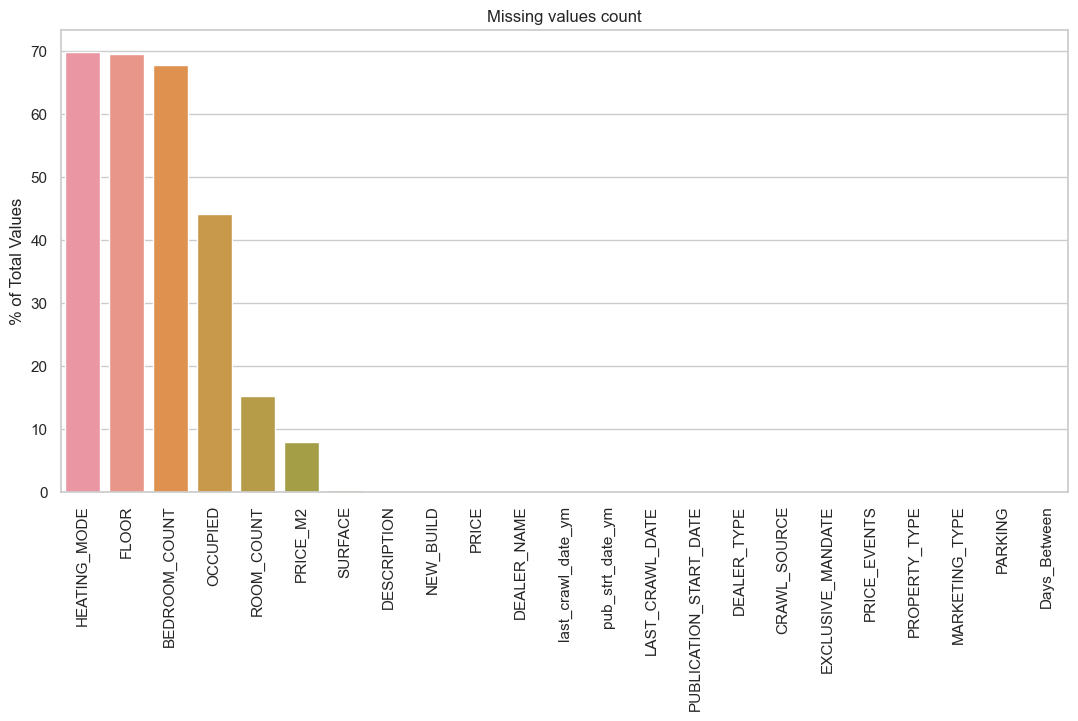

In [31]:
missing_values_table(updated_data_useful_4, False)

In [32]:
updated_data_useful_4 = updated_data_useful_4.drop(columns=['HEATING_MODE', 'FLOOR', 'BEDROOM_COUNT', 'OCCUPIED', 'PRICE_M2'])

Your selected dataframe has 18 columns.



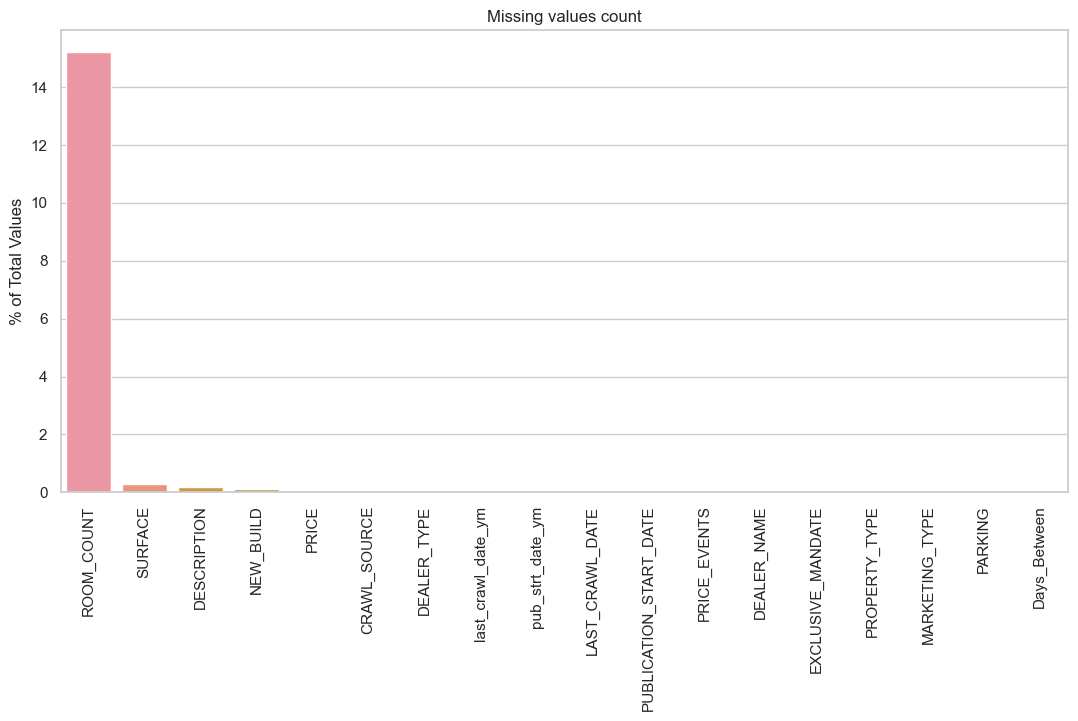

,Missing Values,% of Total Values,Type
ROOM_COUNT,329,15.2,float64
SURFACE,7,0.3,float64
DESCRIPTION,4,0.2,str
NEW_BUILD,3,0.1,str
PRICE,1,0.0,float64
CRAWL_SOURCE,0,0.0,str
DEALER_TYPE,0,0.0,str
last_crawl_date_ym,0,0.0,str
pub_strt_date_ym,0,0.0,str
LAST_CRAWL_DATE,0,0.0,datetime64[ns]


In [33]:
missing_values_table(updated_data_useful_4)

In [34]:
updated_data_useful_4.to_csv('sub_data.csv')

----------------------------------------------------------------------------------------------------------------------------------------------------------

### Objectif:

Le but de cette partie est d'entraîner un modèle de machine learning pour remplir les valeurs manquantes de la variable <mark>ROOM_COUNT</mark>, en fait nous allons considérer un problème supervisé avec <mark>ROOM_COUNT</mark> comme variable cible.
- Nous avons commencé par construire notre base de données, qui se compose de 5 variables explicatives et de la variable cible.
- Nous avons divisé notre base de données en données de test, les lignes avec des valeurs manquantes de la variable cible, et le reste de la base de données, qui consiste pour l'essentiel en notre base de données d'entrainnement et de validation.
- Après avoir construit et validé notre modèle (Random Forest), nous avons prédit les valeurs manquantes de la variable cible avec ce dérnier.

In [35]:
#import data

data = pd.read_csv('..\data\sub_data.csv')


# Preparation of data
target = 'ROOM_COUNT' # Variable cible qu'on veut remplir à la fin
model_var = ['PROPERTY_TYPE', 'NEW_BUILD', 'SURFACE', 'PRICE', 'EXCLUSIVE_MANDATE', 'MARKETING_TYPE'] # nos variables que nous avons choisi
model_data = data[model_var + [target]]

In [36]:
# Fonction pour supprimer les lignes avec des valeurs manquantes

def drop_rows_with_missing_values(data, columns_to_check):
    
    missing_values = data[columns_to_check].isnull().any(axis=1)

    data_cleaned = data[~missing_values]

    return data_cleaned

In [37]:
model_data = drop_rows_with_missing_values(model_data, model_var)

In [38]:
# model_data.dropna(subset=['NEW_BUILD', 'SURFACE', 'PRICE'], inplace=True)

In [39]:
model_data.isna().sum()

PROPERTY_TYPE          0
NEW_BUILD              0
SURFACE                0
PRICE                  0
EXCLUSIVE_MANDATE      0
MARKETING_TYPE         0
ROOM_COUNT           325
dtype: int64

In [40]:
# Dans cette section, nous essayons d'encoder nos variables catégorielles.

In [41]:
from sklearn.preprocessing import OrdinalEncoder

enc = OrdinalEncoder()
enc.fit(model_data[["PROPERTY_TYPE"]])
model_data[["PROPERTY_TYPE"]] = enc.transform(model_data[["PROPERTY_TYPE"]])

In [42]:

model_data["EXCLUSIVE_MANDATE"] = model_data["EXCLUSIVE_MANDATE"].astype(int)

In [43]:
model_data['NEW_BUILD'] = model_data['NEW_BUILD'].map({'True': 1, 'False': 0, '-1': -1})

In [44]:
model_data['MARKETING_TYPE'] = model_data['MARKETING_TYPE'].map({'RENT': 1, 'SALE': 0})

#### Notre dataset resemble à cela : 

In [45]:
model_data.head()

,PROPERTY_TYPE,NEW_BUILD,SURFACE,PRICE,EXCLUSIVE_MANDATE,MARKETING_TYPE,ROOM_COUNT
0,0.0,0,72.0,1979.0,0,1,3.0
1,0.0,0,48.0,429000.0,0,0,2.0
2,0.0,0,267.0,4970000.0,0,0,6.0
3,4.0,0,50.0,89.0,0,1,0.0
4,2.0,0,330.0,2790000.0,0,0,8.0


In [46]:
# Nous allons essayer d'extraire la base test avec les valeurs manquantes, et la base d'entr et de validation sans valeurs manquantes.

data_with_missing = model_data[model_data[target].isna()]
data_without_missing = model_data.dropna(subset=[target])

In [47]:
X = data_without_missing.drop(columns=[target])
y = data_without_missing[target]

In [48]:
# diviser X et y en ensembles de training et testing

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [49]:
X.isna().sum()

PROPERTY_TYPE        0
NEW_BUILD            0
SURFACE              0
PRICE                0
EXCLUSIVE_MANDATE    0
MARKETING_TYPE       0
dtype: int64

In [50]:
# Model 

from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=-1, oob_score=False,
                       random_state=123, verbose=0, warm_start=False)

clf.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=123)

In [51]:
y_pred_test = clf.predict(X_test)

In [52]:
from sklearn.metrics import accuracy_score

print('Model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred_test)))

Model accuracy score: 0.9344


In [53]:
from sklearn.metrics import balanced_accuracy_score

print('Model balanced accuracy score: {0:0.4f}'. format(balanced_accuracy_score(y_test, y_pred_test)))

Model balanced accuracy score: 0.8532


#### Nous avons essayé de travailler avec une balanced accuracy parce qu'il y a un déséquilibre dans notre variable cible.
#### Comme nous pouvons le constater, notre accuracy est très bonne. (85%)

In [54]:
# Prédire les valeurs cibles manquantes
X_with_missing = data_with_missing.drop(columns=[target])
predicted_values = clf.predict(X_with_missing)

In [55]:
data_with_missing[target] = predicted_values

final_data = pd.concat([data_with_missing, data_without_missing])

C:\Users\Amine\AppData\Local\Temp\ipykernel_12020\2077759636.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_with_missing[target] = predicted_values


In [56]:
final_data

,PROPERTY_TYPE,NEW_BUILD,SURFACE,PRICE,EXCLUSIVE_MANDATE,MARKETING_TYPE,ROOM_COUNT
7,3.0,-1,16.00,60.0,0,1,1.0
8,3.0,-1,11.00,100.0,0,1,1.0
10,4.0,0,95.00,64500.0,0,0,0.0
17,4.0,0,1105.00,25783.0,0,1,0.0
18,3.0,-1,12.74,20000.0,0,0,1.0
...,...,...,...,...,...,...,...
2158,0.0,0,121.70,1250000.0,0,0,5.0
2159,0.0,0,50.00,465000.0,0,0,2.0
2160,0.0,0,31.00,1010.0,0,1,2.0
2161,0.0,0,67.00,719000.0,0,0,3.0


-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [57]:
# Localiser et remplir
data.loc[X_with_missing.index, "ROOM_COUNT"] = predicted_values

In [58]:
## enregistrer les données dans un fichier 'new_data.csv'
data.to_csv('new_data.csv')

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Objectif :

#### Cette partie décris la méthodologie, les algorithmes et les pistes d’améliorations.
- Premièrement j'ai essayer de reduire la taille du problème en appliquant **K_means** sur ma base sans la variable '**Description**' pour avoir mes premiers clusters.
- Ensuite, je me suis ensuite concentré sur la variable "**Description**", j'ai fait un peu de traitement de texte et j'ai calculé le cos similarité (cosine_similarity) entre chaque description et les autres (pairwise_distances). Une fois ce calcul effectué, j'ai construit mes seconds clusters.
- Enfin, j'ai construit une matrice de similarité entre les variables de ma nouvelle base de données, cette fois-ci avec mes nouvelles variables de cluster. <mark>J'ai essayé de décrire plus en détail cette approche à la fin du notebook (**Merci ce la voir**)</mark>.

In [59]:
# imports
from sklearn.metrics import pairwise_distances

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

from sklearn.compose import make_column_transformer


In [60]:
# load newest data
DATA_PATH = "../data/new_data.csv"

data = pd.read_csv(DATA_PATH)

Your selected dataframe has 20 columns.



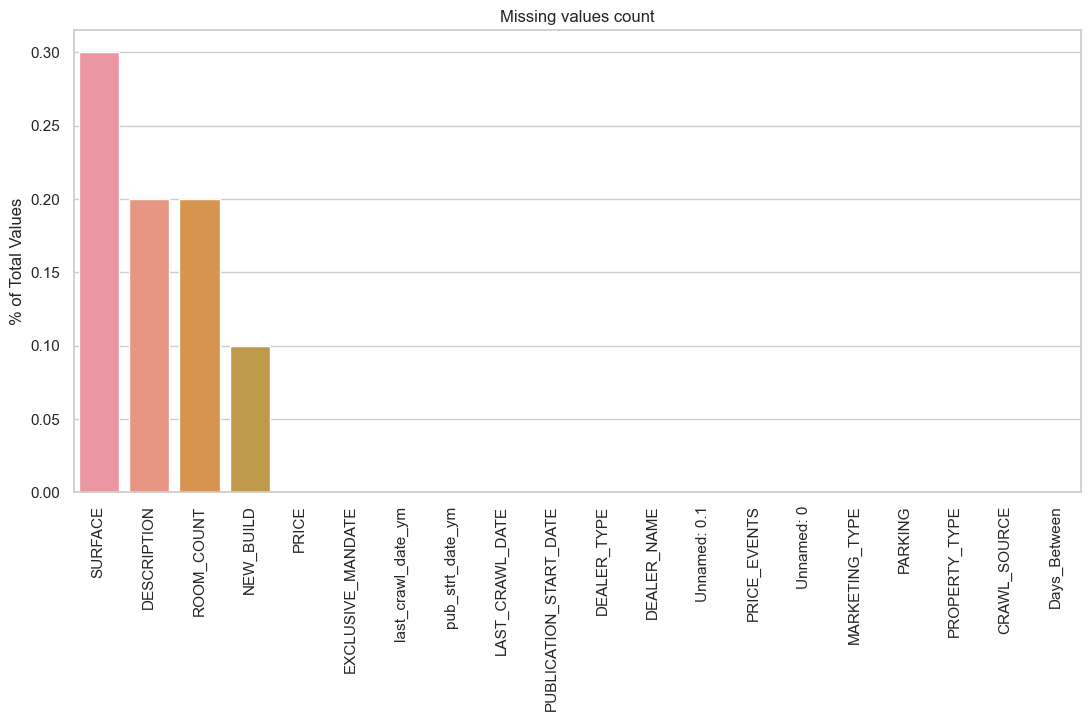

,Missing Values,% of Total Values,Type
SURFACE,7,0.3,float64
DESCRIPTION,4,0.2,str
ROOM_COUNT,4,0.2,float64
NEW_BUILD,3,0.1,str
PRICE,1,0.0,float64
EXCLUSIVE_MANDATE,0,0.0,bool
last_crawl_date_ym,0,0.0,str
pub_strt_date_ym,0,0.0,str
LAST_CRAWL_DATE,0,0.0,str
PUBLICATION_START_DATE,0,0.0,str


In [61]:
missing_values_table(data)

#### Pour cette nouvelle base, qui ne comporte pratiquement pas de valeurs manquantes (0.3% pour la plus grande), j'ai décidé de les supprimer pour cette phase de modélisation.

In [62]:
data.head(2)

,Unnamed: 0.1,Unnamed: 0,CRAWL_SOURCE,PROPERTY_TYPE,NEW_BUILD,DESCRIPTION,SURFACE,ROOM_COUNT,PARKING,MARKETING_TYPE,PRICE,PRICE_EVENTS,EXCLUSIVE_MANDATE,DEALER_NAME,DEALER_TYPE,PUBLICATION_START_DATE,LAST_CRAWL_DATE,pub_strt_date_ym,last_crawl_date_ym,Days_Between
0,0,0,A_VENDRE_A_LOUER,APARTMENT,False,"Au rez de chaussée d'un bel immeuble récent,ap...",72.0,3.0,True,RENT,1979.0,"[{""price"":1979,""date"":""2017-03-22""}]",False,Lamirand Et Associes,AGENCY,2017-03-22 04:07:56.095,2017-04-21 18:52:35.733,2017-03,2017-04,30
1,1,1,BIEN_ICI,APARTMENT,False,Je vous propose un appartement dans la rue Col...,48.0,2.0,False,SALE,429000.0,"[{""price"":452000.0,""date"":""2018-09-18""},{""pric...",False,Proprietes Privees,MANDATARY,2018-09-18 11:04:44.461,2019-06-06 10:08:10.890,2018-09,2019-06,260


In [63]:
# Colonnes à exploiter ultérieurement
USELESS_COL = [
    "CRAWL_SOURCE",  "DEALER_NAME",
    'pub_strt_date_ym', 'last_crawl_date_ym',
    'Unnamed: 0.1', 'Unnamed: 0',
    "PRICE_EVENTS"
]
data_useful = data.drop(labels=USELESS_COL, axis=1)

In [64]:
data_useful.head()

,PROPERTY_TYPE,NEW_BUILD,DESCRIPTION,SURFACE,ROOM_COUNT,PARKING,MARKETING_TYPE,PRICE,EXCLUSIVE_MANDATE,DEALER_TYPE,PUBLICATION_START_DATE,LAST_CRAWL_DATE,Days_Between
0,APARTMENT,False,"Au rez de chaussée d'un bel immeuble récent,ap...",72.0,3.0,True,RENT,1979.0,False,AGENCY,2017-03-22 04:07:56.095,2017-04-21 18:52:35.733,30
1,APARTMENT,False,Je vous propose un appartement dans la rue Col...,48.0,2.0,False,SALE,429000.0,False,MANDATARY,2018-09-18 11:04:44.461,2019-06-06 10:08:10.890,260
2,APARTMENT,False,"Dans un cadre arboré, calme et fleuri, un pent...",267.0,6.0,False,SALE,4970000.0,False,AGENCY,2019-02-19 16:49:03.547,2019-06-13 08:22:14.314,113
3,PREMISES,False,"""Le meilleur coworking flexible de la ville, 5...",50.0,0.0,False,RENT,89.0,False,AGENCY,2018-07-06 15:18:59.805,2019-06-18 10:40:07.405,346
4,HOUSE,False,Levallois - Parc de la Planchette A toute prox...,330.0,8.0,False,SALE,2790000.0,False,AGENCY,2019-04-08 17:12:20.123,2019-06-14 15:02:18.155,66


## K-means

#### Tout d'abors je vais commencer par réduire la taille du problème, en essayant de construire nos premières Clusters avec le modèle de K-means.

<mark> **Préparation de la base** </mark>

In [65]:
excluded_column = 'DESCRIPTION'

# Sélectionner toutes les colonnes à l'exception de la colonne Description
k_variables = data_useful.drop(columns=[excluded_column]).columns
k_variables

Index(['PROPERTY_TYPE', 'NEW_BUILD', 'SURFACE', 'ROOM_COUNT', 'PARKING',
       'MARKETING_TYPE', 'PRICE', 'EXCLUSIVE_MANDATE', 'DEALER_TYPE',
       'PUBLICATION_START_DATE', 'LAST_CRAWL_DATE', 'Days_Between'],
      dtype='object')

In [66]:
Kmeans_data = data_useful[k_variables]

In [67]:
# to_ date pour les varibles date

# Kmeans_data['PUBLICATION_START_DATE'] = pd.to_datetime(Kmeans_data['PUBLICATION_START_DATE'])
# Kmeans_data['LAST_CRAWL_DATE'] = pd.to_datetime(Kmeans_data['LAST_CRAWL_DATE'])

In [68]:
Kmeans_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2164 entries, 0 to 2163
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   PROPERTY_TYPE           2164 non-null   object 
 1   NEW_BUILD               2161 non-null   object 
 2   SURFACE                 2157 non-null   float64
 3   ROOM_COUNT              2160 non-null   float64
 4   PARKING                 2164 non-null   bool   
 5   MARKETING_TYPE          2164 non-null   object 
 6   PRICE                   2163 non-null   float64
 7   EXCLUSIVE_MANDATE       2164 non-null   bool   
 8   DEALER_TYPE             2164 non-null   object 
 9   PUBLICATION_START_DATE  2164 non-null   object 
 10  LAST_CRAWL_DATE         2164 non-null   object 
 11  Days_Between            2164 non-null   int64  
dtypes: bool(2), float64(3), int64(1), object(6)
memory usage: 173.4+ KB


<mark> **Encoder nos variables catégorielles** </mark>

In [69]:
enc = OrdinalEncoder()
enc.fit(Kmeans_data[["PROPERTY_TYPE"]])
Kmeans_data[["PROPERTY_TYPE"]] = enc.transform(Kmeans_data[["PROPERTY_TYPE"]])

C:\Users\Amine\AppData\Local\Temp\ipykernel_12020\2214458375.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Kmeans_data[["PROPERTY_TYPE"]] = enc.transform(Kmeans_data[["PROPERTY_TYPE"]])


In [70]:
Kmeans_data["EXCLUSIVE_MANDATE"] = Kmeans_data["EXCLUSIVE_MANDATE"].astype(int)
Kmeans_data["PARKING"] = Kmeans_data["PARKING"].astype(int)
Kmeans_data['NEW_BUILD'] = Kmeans_data['NEW_BUILD'].map({'True': 1, 'False': 0, '-1': -1})
Kmeans_data['MARKETING_TYPE'] = Kmeans_data['MARKETING_TYPE'].map({'RENT': 1, 'SALE': 0})

C:\Users\Amine\AppData\Local\Temp\ipykernel_12020\1286886479.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Kmeans_data["EXCLUSIVE_MANDATE"] = Kmeans_data["EXCLUSIVE_MANDATE"].astype(int)
C:\Users\Amine\AppData\Local\Temp\ipykernel_12020\1286886479.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Kmeans_data["PARKING"] = Kmeans_data["PARKING"].astype(int)
C:\Users\Amine\AppData\Local\Temp\ipykernel_12020\1286886479.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

In [71]:
enc.fit(Kmeans_data[["DEALER_TYPE"]])
Kmeans_data[['DEALER_TYPE']] = enc.transform(Kmeans_data[["DEALER_TYPE"]])

C:\Users\Amine\AppData\Local\Temp\ipykernel_12020\40140738.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Kmeans_data[['DEALER_TYPE']] = enc.transform(Kmeans_data[["DEALER_TYPE"]])


In [72]:
Kmeans_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2164 entries, 0 to 2163
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   PROPERTY_TYPE           2164 non-null   float64
 1   NEW_BUILD               2161 non-null   float64
 2   SURFACE                 2157 non-null   float64
 3   ROOM_COUNT              2160 non-null   float64
 4   PARKING                 2164 non-null   int32  
 5   MARKETING_TYPE          2164 non-null   int64  
 6   PRICE                   2163 non-null   float64
 7   EXCLUSIVE_MANDATE       2164 non-null   int32  
 8   DEALER_TYPE             2164 non-null   float64
 9   PUBLICATION_START_DATE  2164 non-null   object 
 10  LAST_CRAWL_DATE         2164 non-null   object 
 11  Days_Between            2164 non-null   int64  
dtypes: float64(6), int32(2), int64(2), object(2)
memory usage: 186.1+ KB


In [73]:
from datetime import datetime

# Définir la fonction permettant de convertir une chaîne de date et d'heure en un horodatage
def date_time_to_timestamp(date_time_str, reference_date_time_str):
    reference_date_time_obj = datetime.strptime(reference_date_time_str, '%Y-%m-%d %H:%M:%S.%f')
    date_time_obj = datetime.strptime(date_time_str, '%Y-%m-%d %H:%M:%S.%f')
    time_difference = date_time_obj - reference_date_time_obj
    return time_difference.total_seconds()


# Définir la date et l'heure de référence sous forme de chaîne (en supposant qu'il s'agit de la date minimale de 'PUBLICATION_START_DATE')
reference_date_time_str = '2015-01-01 00:00:50.00' 

# Appliquer la conversion de la date en horodatage à l'ensemble du DataFrame et créer une nouvelle colonne "TIMESTAMP".

Kmeans_data['PUBLICATION_START_TIMESTAMP'] = Kmeans_data['PUBLICATION_START_DATE'].apply(
    lambda date_time_str: date_time_to_timestamp(date_time_str, reference_date_time_str)
)

Kmeans_data['LAST_CRAWL_DATE_TIMESTAMP'] = Kmeans_data['LAST_CRAWL_DATE'].apply(
    lambda date_time_str: date_time_to_timestamp(date_time_str, reference_date_time_str)
)


In [74]:
Kmeans_data = Kmeans_data.drop(columns= ['PUBLICATION_START_DATE', 'LAST_CRAWL_DATE']) # J'ai supp les variables date après avoir exploiter et changer en variables numériques

In [75]:
Kmeans_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2164 entries, 0 to 2163
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   PROPERTY_TYPE                2164 non-null   float64
 1   NEW_BUILD                    2161 non-null   float64
 2   SURFACE                      2157 non-null   float64
 3   ROOM_COUNT                   2160 non-null   float64
 4   PARKING                      2164 non-null   int32  
 5   MARKETING_TYPE               2164 non-null   int64  
 6   PRICE                        2163 non-null   float64
 7   EXCLUSIVE_MANDATE            2164 non-null   int32  
 8   DEALER_TYPE                  2164 non-null   float64
 9   Days_Between                 2164 non-null   int64  
 10  PUBLICATION_START_TIMESTAMP  2164 non-null   float64
 11  LAST_CRAWL_DATE_TIMESTAMP    2164 non-null   float64
dtypes: float64(8), int32(2), int64(2)
memory usage: 186.1 KB


In [76]:
# Fonction pour supprimer les lignes avec des valeurs manquantes en spécifiant le nom de la colonne 

def drop_rows_with_missing_values(data, columns_to_check):
    
    missing_values = data[columns_to_check].isnull().any(axis=1)

    data_cleaned = data[~missing_values]

    return data_cleaned



In [77]:
Kmeans_data = drop_rows_with_missing_values(Kmeans_data, Kmeans_data.columns)

In [78]:
Kmeans_data.isna().sum()

PROPERTY_TYPE                  0
NEW_BUILD                      0
SURFACE                        0
ROOM_COUNT                     0
PARKING                        0
MARKETING_TYPE                 0
PRICE                          0
EXCLUSIVE_MANDATE              0
DEALER_TYPE                    0
Days_Between                   0
PUBLICATION_START_TIMESTAMP    0
LAST_CRAWL_DATE_TIMESTAMP      0
dtype: int64

#### Elbow Graph 

#### Afin de d'identifier le k optimale pour notre K-means, j'ai utilisé le graph Elbow

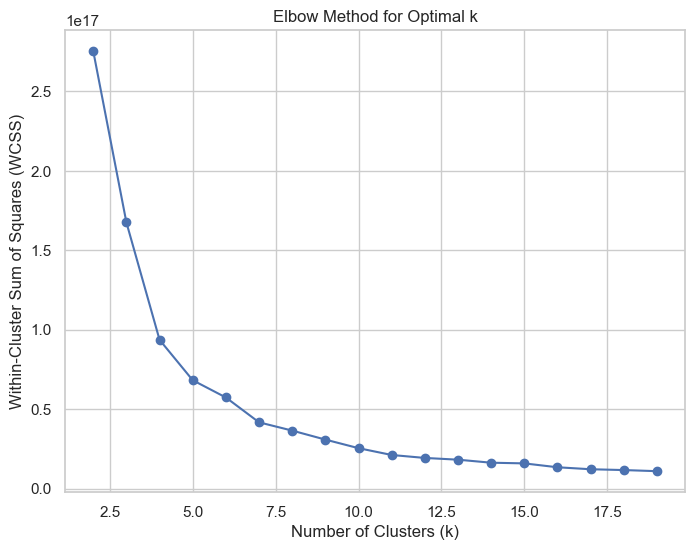

In [79]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

wcss = []


k_range = range(2, 20)  

for k in k_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=1, random_state=0)
    kmeans.fit(Kmeans_data)  
    wcss.append(kmeans.inertia_)

# Plot the Elbow curve
plt.figure(figsize=(8, 6))
plt.plot(k_range, wcss, marker='o', linestyle='-', color='b')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.grid(True)
plt.show()

#### On observe un k moyen de 7

### Entrainement du modèle k-means

In [80]:
k=7
kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=1, random_state=0)
kmeans.fit(Kmeans_data)  

KMeans(max_iter=100, n_clusters=7, n_init=1, random_state=0)

In [81]:
cluster_labels = kmeans.predict(Kmeans_data)
Kmeans_data['kmeans_cluster'] = cluster_labels

#### Affectation des valeurs de la colonne "**kmeans_cluster**" du DataFrame "**data_useful**"

In [82]:
data_useful.loc[Kmeans_data.index, "kmeans_cluster"] = Kmeans_data['kmeans_cluster']

In [83]:
data_useful['kmeans_cluster'].value_counts()

0.0    1325
4.0     551
2.0     137
3.0      51
5.0      40
1.0      36
6.0      13
Name: kmeans_cluster, dtype: int64

----------------------------------------------------------------------------------------------------------------------

## Exploitation de la variable **'DESCRIPTION'**

In [84]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
from sklearn.feature_extraction.text import TfidfVectorizer

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity



# download nltk corpus (first time only)
import nltk

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Amine\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Amine\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Amine\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [85]:
data_useful.head(3)

,PROPERTY_TYPE,NEW_BUILD,DESCRIPTION,SURFACE,ROOM_COUNT,PARKING,MARKETING_TYPE,PRICE,EXCLUSIVE_MANDATE,DEALER_TYPE,PUBLICATION_START_DATE,LAST_CRAWL_DATE,Days_Between,kmeans_cluster
0,APARTMENT,False,"Au rez de chaussée d'un bel immeuble récent,ap...",72.0,3.0,True,RENT,1979.0,False,AGENCY,2017-03-22 04:07:56.095,2017-04-21 18:52:35.733,30,1.0
1,APARTMENT,False,Je vous propose un appartement dans la rue Col...,48.0,2.0,False,SALE,429000.0,False,MANDATARY,2018-09-18 11:04:44.461,2019-06-06 10:08:10.890,260,2.0
2,APARTMENT,False,"Dans un cadre arboré, calme et fleuri, un pent...",267.0,6.0,False,SALE,4970000.0,False,AGENCY,2019-02-19 16:49:03.547,2019-06-13 08:22:14.314,113,4.0


In [86]:
data_useful['DESCRIPTION'] = data_useful['DESCRIPTION'].fillna('')
data_useful['DESCRIPTION'] = data_useful['DESCRIPTION'].apply(preprocess_text_nltk) # prend quelques secondes 

# TF-IDF
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(data_useful['DESCRIPTION'])
text_similarity = cosine_similarity(tfidf_matrix)

In [87]:
similarity_threshold = 0.8 # J'ai fixé un seuil de similitude de .8, mais ce seuil peut être ajusté.

# identifier les paires dupliquées
duplicate_pairs = []
for i in range(len(data_useful)):
    for j in range(i+1, len(data_useful)):
        if text_similarity[i][j] > similarity_threshold:
            duplicate_pairs.append((i, j))

In [88]:
text_IDs = {}

duplicate_df_list = []

id_counter = 1

# Traiter les paires dupliquées
for idx, (i, j) in enumerate(duplicate_pairs):
    set_id_i = text_IDs.get(i, None)
    set_id_j = text_IDs.get(j, None)

    # Si les deux documents ont déjà des identifiants, conserver le plus petit.
    if set_id_i is not None and set_id_j is not None:
        min_id = min(set_id_i, set_id_j)
        text_IDs[i] = min_id
        text_IDs[j] = min_id
    else:
        # Si l'un d'entre eux a un identifiant, utilisez le même identifiant.
        if set_id_i is not None:
            text_IDs[j] = set_id_i
        elif set_id_j is not None:
            text_IDs[i] = set_id_j
        else:
            # Aucun n'a d'identifiant, attribuer un nouvel identifiant unique
            text_IDs[i] = id_counter
            text_IDs[j] = id_counter
            id_counter += 1

In [89]:
# Attribuer des identifiants uniques aux annonces qui ne font pas partie d'un ensemble de doublons.
for i in range(len(data_useful)):
    if i not in text_IDs:
        text_IDs[i] = id_counter
        id_counter += 1

data_useful['text_ID'] = [text_IDs[i] for i in range(len(data_useful))]

data_useful

,PROPERTY_TYPE,NEW_BUILD,DESCRIPTION,SURFACE,ROOM_COUNT,PARKING,MARKETING_TYPE,PRICE,EXCLUSIVE_MANDATE,DEALER_TYPE,PUBLICATION_START_DATE,LAST_CRAWL_DATE,Days_Between,kmeans_cluster,text_ID
0,APARTMENT,False,rez chaussée dun bel immeuble récent appartem...,72.00,3.0,True,RENT,1979.0,False,AGENCY,2017-03-22 04:07:56.095,2017-04-21 18:52:35.733,30,1.0,376
1,APARTMENT,False,propose appartement rue collange immeuble stan...,48.00,2.0,False,SALE,429000.0,False,MANDATARY,2018-09-18 11:04:44.461,2019-06-06 10:08:10.890,260,2.0,377
2,APARTMENT,False,cadre arboré calme fleuri penthouse 267 m² t...,267.00,6.0,False,SALE,4970000.0,False,AGENCY,2019-02-19 16:49:03.547,2019-06-13 08:22:14.314,113,4.0,1
3,PREMISES,False,meilleur coworking flexible ville 50 m² salo...,50.00,0.0,False,RENT,89.0,False,AGENCY,2018-07-06 15:18:59.805,2019-06-18 10:40:07.405,346,2.0,2
4,HOUSE,False,levallois parc planchette a toute proximité p...,330.00,8.0,False,SALE,2790000.0,False,AGENCY,2019-04-08 17:12:20.123,2019-06-14 15:02:18.155,66,4.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2159,APARTMENT,False,levalloisperret bel appartement idéalement si...,50.00,2.0,False,SALE,465000.0,False,AGENCY,2019-05-29 03:19:57.728,2019-08-27 10:42:10.913,90,0.0,160
2160,APARTMENT,False,300 mètres métro pont levallois bécon 1er éta...,31.00,2.0,False,RENT,1010.0,False,AGENCY,2019-08-27 01:41:33.163,2019-08-27 01:41:33.163,0,0.0,375
2161,APARTMENT,False,levallois rue barbes immeuble récent 1er éta...,67.00,3.0,False,SALE,719000.0,False,AGENCY,2019-08-27 00:08:01.676,2019-08-27 00:08:01.676,0,0.0,1211
2162,PARKING,-1,levalloisperret rue paul vaillant couturier ...,12.74,1.0,False,RENT,95.0,True,AGENCY,2019-07-06 10:07:45.114,2019-08-27 11:53:04.317,52,0.0,76


In [90]:
import plotly.express as px

value_counts = data_useful["text_ID"].value_counts().reset_index()
value_counts.columns = ['text_ID', 'Count']

fig = px.bar(value_counts, x='text_ID', y='Count', title='Distribution of text IDs')

fig.update_layout(
    xaxis_title='text_ID',
    yaxis_title='Count',
    xaxis=dict(type='category')
)

fig.show()

#### Ce graphique nous permet de voir qu'il y a des doublons dans la base de données en effectuant une analyse de similarité entre les descriptions d'annonces, mais bien sur il y a des faux positives, mais cette approche nous a tout de même permis de faire un nouveau clustrage.

In [91]:
f_df = data_useful["text_ID"].value_counts().reset_index()
f_df.columns = ['Class', 'Count']
f_df

,Class,Count
0,111,43
1,190,11
2,40,9
3,231,8
4,121,8
...,...,...
1204,675,1
1205,676,1
1206,677,1
1207,678,1


In [92]:
import plotly.express as px

value_counts = pd.Series(f_df["Count"].values).value_counts().reset_index()
value_counts.columns = ['Value', 'Count']
value_counts['Percentage'] = (value_counts['Count'] / value_counts['Count'].sum()) * 100

fig = px.pie(value_counts, names='Value', values='Percentage', title='Pie Chart of Value Percentages')
fig.show()

#### On observe le pourcentage des classes en fonction des doublons.

#### Example pour le cas de l'indice 20

In [93]:
data_useful[data_useful["text_ID"] == 20]

,PROPERTY_TYPE,NEW_BUILD,DESCRIPTION,SURFACE,ROOM_COUNT,PARKING,MARKETING_TYPE,PRICE,EXCLUSIVE_MANDATE,DEALER_TYPE,PUBLICATION_START_DATE,LAST_CRAWL_DATE,Days_Between,kmeans_cluster,text_ID
37,APARTMENT,True,bnp paribas immobilier 120 danton levalloispe...,47.0,2.0,False,SALE,475000.0,False,AGENCY,2019-07-30 08:25:27.695,2019-08-12 18:40:10.865,13,0.0,20
1940,APARTMENT,True,bnp paribas immobilier 120 danton levalloispe...,58.0,3.0,False,SALE,669000.0,False,AGENCY,2019-07-31 12:10:30.313,2019-08-12 18:40:16.038,12,0.0,20
1944,APARTMENT,True,bnp paribas immobilier 120 danton levalloispe...,110.0,5.0,False,SALE,1293000.0,False,AGENCY,2019-08-12 18:40:34.483,2019-08-12 18:40:34.483,0,0.0,20
1945,APARTMENT,True,bnp paribas immobilier 120 danton levalloispe...,85.0,4.0,False,SALE,955000.0,False,AGENCY,2019-08-01 15:48:09.478,2019-08-12 18:39:47.910,11,0.0,20


--------------------------------------------------------------------------------------------------------------------------------

### Similarity Matrix 

In [94]:
data_useful.head(3)

,PROPERTY_TYPE,NEW_BUILD,DESCRIPTION,SURFACE,ROOM_COUNT,PARKING,MARKETING_TYPE,PRICE,EXCLUSIVE_MANDATE,DEALER_TYPE,PUBLICATION_START_DATE,LAST_CRAWL_DATE,Days_Between,kmeans_cluster,text_ID
0,APARTMENT,False,rez chaussée dun bel immeuble récent appartem...,72.0,3.0,True,RENT,1979.0,False,AGENCY,2017-03-22 04:07:56.095,2017-04-21 18:52:35.733,30,1.0,376
1,APARTMENT,False,propose appartement rue collange immeuble stan...,48.0,2.0,False,SALE,429000.0,False,MANDATARY,2018-09-18 11:04:44.461,2019-06-06 10:08:10.890,260,2.0,377
2,APARTMENT,False,cadre arboré calme fleuri penthouse 267 m² t...,267.0,6.0,False,SALE,4970000.0,False,AGENCY,2019-02-19 16:49:03.547,2019-06-13 08:22:14.314,113,4.0,1


#### Nous avons maintenant deux autres variables **kmeans_cluster** et **text_ID** provenant des deux premiers clusters, qui seront également utilisées pour la dernière phase de l'approche.

In [95]:
data_numerical = data_useful.select_dtypes(include=np.number) # nos variables numériques
data_categorical = data_useful.select_dtypes(exclude=np.number) # nos variables catégorielles

In [96]:
# init transformers
categorical_transformer = make_column_transformer(
    (
        OneHotEncoder(sparse=False),
        data_categorical.columns
    ),
    remainder="drop"
)

numerical_transformer = make_column_transformer(
    (
        SimpleImputer(strategy="constant", fill_value=1e-2),
        data_numerical.columns
    ),
    remainder="drop"
)

In [97]:
# transformer les données
data_categories_transformed = categorical_transformer.fit_transform(data_useful)
data_numerical_transformed = numerical_transformer.fit_transform(data_useful)

# trouver les poids si il y a des nan, cela pour garder le pipeline fonctionnel 
nna_numerical = data_numerical.notna().sum(axis=0)
weights_numericals = nna_numerical / nna_numerical.sum()

nna_categorical = data_categorical.notna().sum(axis=0)
weights_categorical = nna_categorical / nna_categorical.sum()
weights_categorical = np.repeat(
    weights_categorical.values,
    data_categorical.nunique(dropna=False).values
)

# calculer pairwise distance
dist_categories = pairwise_distances(
    X=data_categories_transformed,
    metric="minkowski",
    p=1,
    w=weights_categorical / 2
)

dist_numericals = pairwise_distances(
    X=data_numerical_transformed,
    metric="canberra",
    w=weights_numericals
)

dist =  dist_categories + dist_numericals
dist /= 2

similarity = 1 - dist

c:\Users\Amine\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning:

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.



In [98]:
# déduire  labels
threshold = 0.8 # Ce seuil peut être ajusté pour obtenir de meilleures performances

similarity_binary = np.where(similarity >= threshold, 1, 0)
labels = np.argmax(similarity_binary, axis=1)

data["LABEL"] = labels

In [99]:
len(data["LABEL"].unique())

1124

In [100]:
data["LABEL"].value_counts()

222     38
323     22
149     16
409     14
44      14
        ..
822      1
823      1
824      1
829      1
2162     1
Name: LABEL, Length: 1124, dtype: int64

# Example

## Nous allons prendre un exemple pour voir à quoi ressemble notre résultat.

In [101]:
queried_data = data.query("LABEL == 222")

for i in range(len(queried_data)):
   print(queried_data["DESCRIPTION"].iloc[i])
   print("***********")

Une adresse de choix pour devenir propriétaire. La station de métro, le lycée et les commerces sont accessibles à pied dans un rayon de 500 m*. Vous apprécierez la qualité résidentielle de la commune et choisirez parmi une typologie variée d'appartements du studio au 5 pièces duplex. Les espaces intérieurs sont pour la plupart prolongés d'agréables extérieurs, balcons, terrasses ou jardins privatifs. Un coeur d'îlot paysagrer et des espaces communs végétalisés avec cheminements piétons desservent les différents halls d'entrée sécurisés. *Source: Google Maps.
***********
Une adresse de choix pour devenir propriétaire. La station de métro, le lycée et les commerces sont accessibles à pied dans un rayon de 500 m*. Vous apprécierez la qualité résidentielle de la commune et choisirez parmi une typologie variée d'appartements du studio au 5 pièces duplex. Les espaces intérieurs sont pour la plupart prolongés d'agréables extérieurs, balcons, terrasses ou jardins privatifs. Un coeur d'îlot pay

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Approche Matrice de similarité 
##### **(le 3 point évoqué au début dans la partie objectif)**


Pour identifier les échantillons similaires, nous procédons en deux phases :
1. définir un concept de similarité : Étant donné deux échantillons, évaluer dans quelle mesure ils peuvent être considérés comme similaires.
2. regrouper les échantillons similaires : Regrouper les mêmes échantillons au sein d'une même Cluster


### Définition d'une mesure de similarité

Chaque échantillon est décrit par des caractéristiques (SURFACE, TYPE D'APPARTEMENT, ...) et peut donc être traité comme un vecteur. Cependant, il n'est pas évident de définir une similarité entre ces vecteurs, car l'exploration des données a révélé des défis majeurs à relever, notamment les caractéristiques suivantes :
- catégorique et numérique
- hétérogènes donc non additionnables (PRIX, SURFACE)
- constituées de valeurs manquantes (j'ai essayé de les gérer)
- légèrement différentes, même pour des "échantillons similaires"

Nous relevons ces défis en comparant tout d'abord chaque caractéristique individuellement.
Nous abordons l'hétérogénéité en choisissant des fonctions de distance et en les normalisant pour qu'elles soient comprises entre 0 et 1 pour l'invariance d'échelle. En particulier, nous utilisons
- Pour les caractéristiques catégorielles : la *distance de Manhattan* normalisée par le nombre total de caractéristiques catégorielles.
- Pour les données numériques : la *distance de Canberra*, synonyme de distance relative.


Enfin, nous tenons compte des valeurs manquantes en pondérant les différences entre les caractéristiques. Nous considérons que les caractéristiques comportant peu de NA sont plus fiables et leur accordons donc plus de poids.

En résumé, à partir de deux échantillons $\mathrm{sample}_1$, $\mathrm{sample}_2$, nous mesurons leur similarité comme suit
$$
	\mathrm{Similarity}(\mathrm{sample}_1, \mathrm{sample}_2) = 1 - \sum_j \mathrm{weight}_j \times \mathrm{distance}(\mathrm{feature}_{j,1}, \mathrm{feature}_{j,2})
$$


### Agrégation d'échantillons similaires
En appliquant la méthode ci-dessus à toutes les paires d'échantillons, nous obtenons une matrice de similarité par paire.
Chaque ligne de la matrice représente la similarité d'un échantillon par rapport à tous les autres échantillons.

Comme l'a montré l'exploration des données, étant donné qu'il existe de légères différences entre les échantillons même s'ils sont "similaires", nous choisissons un seuil au-delà duquel nous pouvons considérer que deux échantillons sont identiques.

Sur la base de ce seuil, nous pouvons assigner chaque échantillon à une grappe comprenant ses échantillons similaires.

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Perspectives

La résolution d'un problème de record linkage revêt une importance cruciale dans le secteur de l'immobilier. Elle permet d'assurer la qualité des données en regroupant les enregistrements similaires ou identiques, éliminant ainsi les doublons et améliorant la précision des informations. Cette démarche s'avère essentielle pour optimiser la recherche et l'analyse immobilières, garantissant des décisions éclairées et des opérations plus efficaces.

En ce qui concerne ma démarche pour résoudre ce problème de record linkage, elle est déjà prometteuse, mais il reste des miss-classification. Cependant, il reste des possibilités d'amélioration, notamment en ce qui concerne l'exploitation de la variable **'DESCRIPTION'**. L'extraction des données manquantes à partir de cette variable représente un avantage considérable. Nous pourrons explorer l'utilisation de modèles de traitement du langage naturel tels que ceux d'OpenAI, en ayant recours à leur API pour extraire des informations à partir du texte. On pourra également envisager de finetuner des modèles open source tels que LLAMA et HuggingFace, ce qui constituerait un ajout précieux à mon approche. L'objectif principal est de maximiser le remplissage des valeurs manquantes.

Par ailleurs, l'exploitation des images est une piste intéressante. Entraîner des modèles de traitement d'images ou finetuner des transformers spécifiquement conçus pour cette tâche peut apporter une grande précision. 

L'intégration de ces approches complémentaires nous permettra d'obtenir des résultats encore plus fiables et complets dans ce type de projet de record linkage pour les annonces immobilières.